In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.stats import chi2_contingency

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, roc_curve, auc, r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from datetime import datetime
from scipy.stats import shapiro, spearmanr, kendalltau
from scipy.stats import mannwhitneyu, kruskal

import warnings
warnings.filterwarnings('ignore')

2024-03-17 15:14:48.931233: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-17 15:14:48.932143: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-17 15:14:48.938176: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-17 15:14:49.003925: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-17 15:14:50.550627

## Informations Dataset

In [4]:
df=pd.read_csv('age_gender.csv')

In [5]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [7]:
nb_doublons = df.duplicated().sum()
print("Nombre de doublons :", nb_doublons)

Nombre de doublons : 0


## Générer des exemples

In [8]:
df['pixels'] = df['pixels'].map(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2)

X = np.array(df['pixels'].to_list())
X_reshaped = X.reshape(X.shape[0], 48, 48, 1)

datagen.fit(X_reshaped)

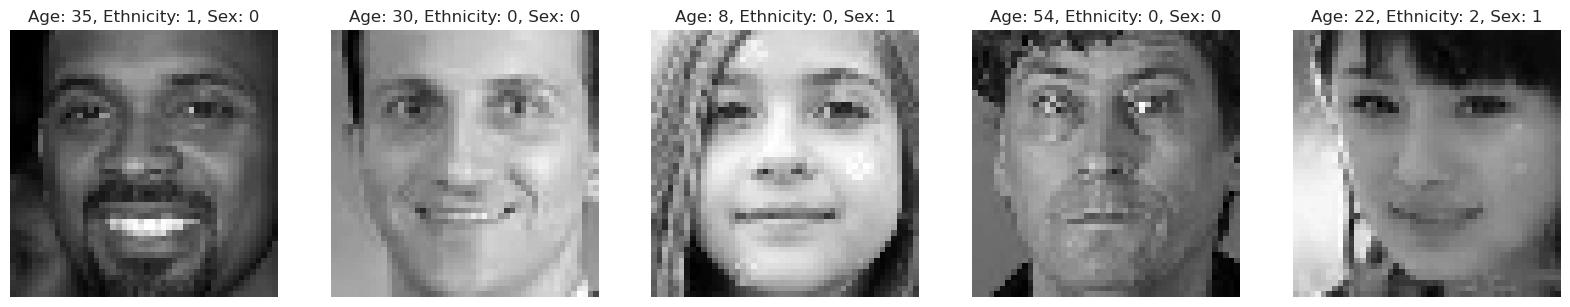

In [9]:
# Plot some pictures
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    random_face = np.random.choice(len(df))
    
    age = df['age'][random_face]
    ethnicity = df['ethnicity'][random_face]
    gender = df['gender'][random_face]
    
    axes[i].set_title('Age: {0}, Ethnicity: {1}, Sex: {2}'.format(age, ethnicity, gender))
    axes[i].imshow(df['pixels'][random_face], cmap = 'gray')
    axes[i].axis('off')

## Data Visualisation

### Variables explicatives

#### Pixels

In [34]:
pixel_count_first_image = len(df['pixels'].loc[0])

# Vérifier si toutes les lignes ont la même longueur que la première
same_length = all(len(row) == pixel_count_first_image for row in df['pixels'])

# Imprimer le résultat
if same_length:
    print("Toutes les lignes ont le même nombre de pixels.")
else:
    print("Les lignes n'ont pas toutes le même nombre de pixels.")

Toutes les lignes ont le même nombre de pixels.


In [37]:
df['pixels'].loc[0].shape

(48, 48)

#### Gender

In [11]:
# Valeurs et Nombre de valeurs distinctes
print(df["gender"].unique())
df["gender"].nunique()

[0 1]


2

In [12]:
# Étendue des valeurs, Équilibre
df["gender"].value_counts()

gender
0    12391
1    11314
Name: count, dtype: int64

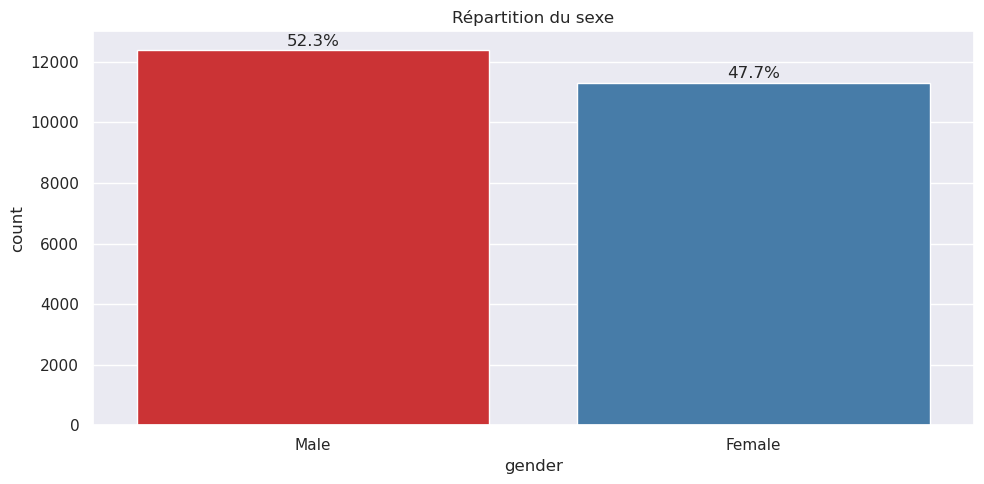

In [13]:
df['gender'] = df['gender'].replace({0: 'Male', 1: 'Female'})
plt.figure(figsize=(10,5))
ax = sns.countplot(x="gender", data=df, palette='Set1', hue='gender', legend=False)  
plt.title("Répartition du sexe")

total = len(df["gender"])
for p in ax.patches:
    percentage = f'{100*p.get_height()/total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')

plt.tight_layout()
plt.show()

#### Ethnicity

In [14]:
# Valeurs et Nombre de valeurs distinctes
df['ethnicity'] = df['ethnicity'].replace({0: 'White', 1: 'Black', 2: 'Asian', 3:'Indian', 4:'Others'})
print(df["ethnicity"].unique())
df["ethnicity"].nunique()

['Asian' 'Indian' 'Others' 'White' 'Black']


5

In [15]:
# Étendue des valeurs, Équilibre
df["ethnicity"].value_counts()

ethnicity
White     10078
Black      4526
Indian     3975
Asian      3434
Others     1692
Name: count, dtype: int64

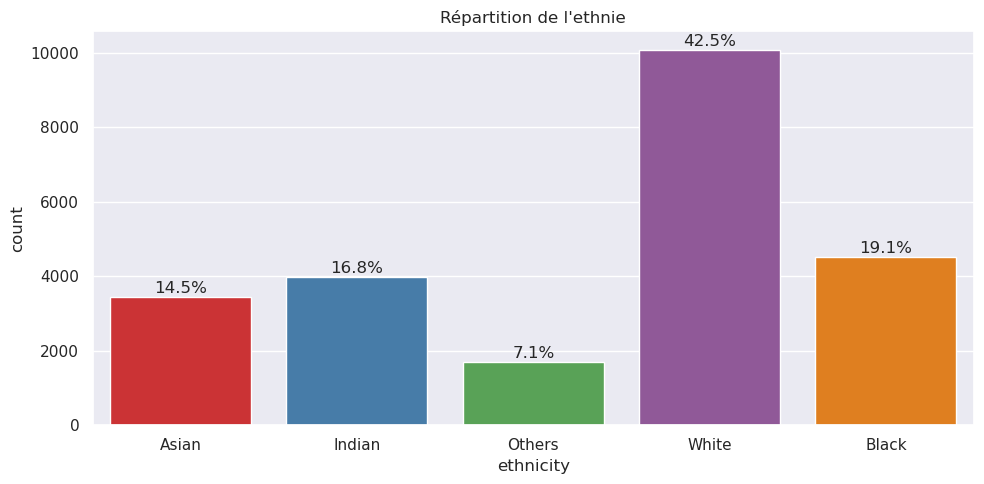

In [16]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x="ethnicity", data=df, palette='Set1', hue='ethnicity', legend=False)  
plt.title("Répartition de l'ethnie")

total = len(df["ethnicity"])
for p in ax.patches:
    percentage = f'{100*p.get_height()/total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')

plt.tight_layout()
plt.show()

### Variable Cible: Age

In [17]:
df["age"].describe()

count    23705.000000
mean        33.300907
std         19.885708
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64

In [18]:
df['age'].median()

29.0

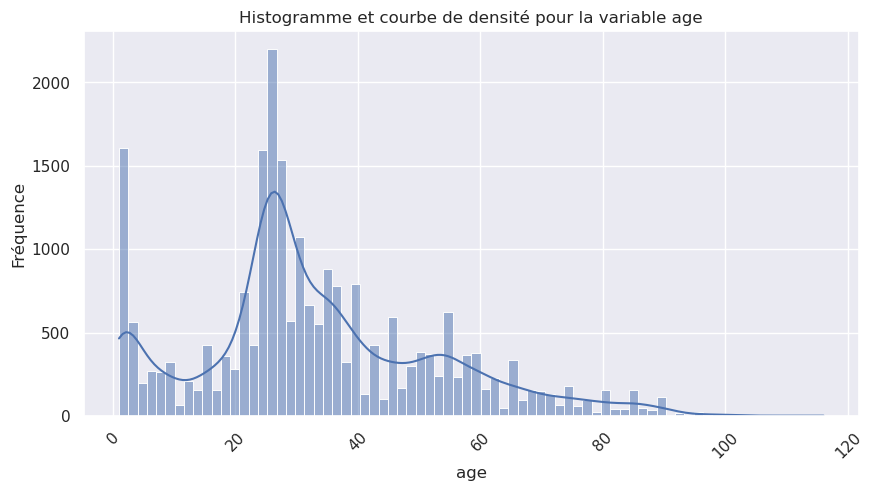

In [19]:
plt.figure(figsize=(10, 5))
df_sorted = df.sort_values('age')
sns.histplot(df_sorted['age'], kde=True)
plt.xlabel('age')
plt.ylabel('Fréquence')
plt.title("Histogramme et courbe de densité pour la variable age")
plt.xticks(rotation=45)  # Modifier cet angle selon tes préférences
plt.show()

In [20]:
# Test de shapiro
stat, p = shapiro(df['age'])

print('Statistique de test :', stat)
print('P-value :', p)

alpha = 0.05
if p > alpha:
    print('La variable est probablement normalement distribuée')
else:
    print('La variable n\'est probablement pas normalement distribuée')

Statistique de test : 0.9568576116569466
P-value : 1.2684022171293143e-62
La variable n'est probablement pas normalement distribuée


## Analyse Statistiques

### Tests Statistiques entre une variables qualitative et quantitative

#### Age & Ethnicity

On a procédé au test de Kruskal-Wallis car la variable Age n'est pas normalement distribuée et Ethnicity a plus de deux modalités.

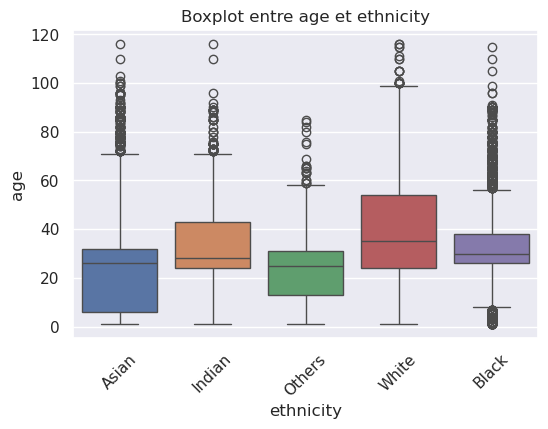

In [21]:
# Graphique de la variable cible en fonction d'ethnicity
plt.figure(figsize=(6, 4))
sns.boxplot(x='ethnicity', y='age', data=df, hue='ethnicity')
plt.xticks(rotation=45)
plt.title('Boxplot entre age et ethnicity')
plt.show()

In [22]:
etats = df['ethnicity'].unique()
data = [df[df['ethnicity'] == etat]['age'] for etat in etats]
statistic, pvalue = kruskal(*data)
print('Statistique du test de Kruskal-Wallis / Ethnicity -> age: ', statistic, ' p-value :', pvalue)

Statistique du test de Kruskal-Wallis / Ethnicity -> age:  1583.4991342709282  p-value : 0.0


La P-value est inférieure à 0.05 : au moins une des distributions d'ethnicity est différente des autres.

Par contre, ce test n'identifie pas où cette dominance se produit ni pour combien de paires de groupes la dominance s'obtient

#### Age & Gender

On a procédé au test de Mann-Whitney car la variable Age n'est pas normalement distribuée et Gender a exactement deux modalités.

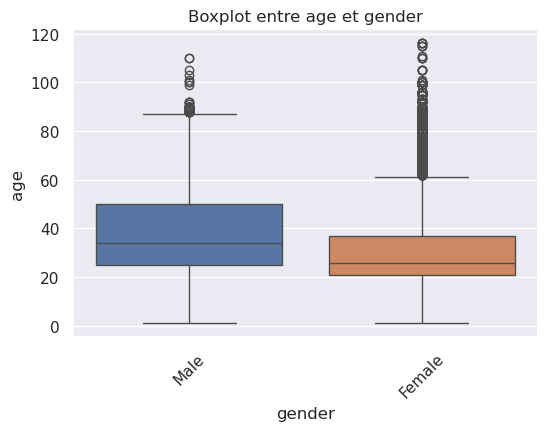

In [23]:
# Graphique de la variable cible en fonction de other_campus_dressing
plt.figure(figsize=(6, 4))
sns.boxplot(x='gender', y='age', data=df, hue='gender')
plt.xticks(rotation=45)
plt.title('Boxplot entre age et gender')
plt.show()

In [24]:
ptypes = df['gender'].unique()
data1 = [df[df['gender'] == ptype]['age'] for ptype in ptypes]
statistic1, pvalue1 = mannwhitneyu(*data1)
print('Statistique du test de Mann-Whitney / gender -> age: ',statistic1, ' p-value :', pvalue1)

Statistique du test de Mann-Whitney / gender -> age:  83679785.0  p-value : 4.2400626187933944e-147


La P-value est inférieure à 0.05 : a une différence significative entre les deux genres en termes d'âge.

### Tests Statistiques entre deux variables qualitatives

#### Gender & Ethnicity

Tout d'abord, on commencera par le test chi-carré pour savoir si une association existe entre les deux variables.

En cas d'association, nous procéderons au test de Cramer-V pour savoir si cette association est forte ou non

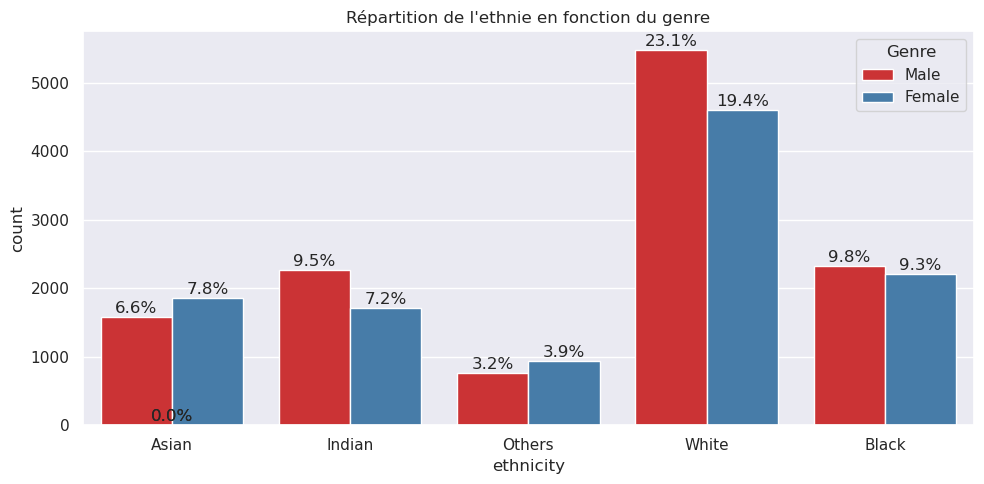

In [25]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x="ethnicity", data=df, palette='Set1', hue='gender')  
plt.title("Répartition de l'ethnie en fonction du genre")

total = len(df["ethnicity"])
for p in ax.patches:
    percentage = f'{100*p.get_height()/total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')

# Ajout de la légende pour le genre
plt.legend(title='Genre', loc='upper right')

plt.tight_layout()
plt.show()

In [26]:
# Tableau de contingence des variables
ct = pd.crosstab(df['ethnicity'], df['gender'])
ct

gender,Female,Male
ethnicity,,
Asian,1859,1575
Black,2208,2318
Indian,1714,2261
Others,932,760
White,4601,5477


In [27]:
# Test du chi-carré
chi2_stat, p_value, dof, expected_freq = chi2_contingency(ct)

print("Statistique du test de chi-carré :", chi2_stat)
print("p_value :", p_value)
print("Degrés de liberté :", dof)

Statistique du test de chi-carré : 146.43237454654127
p_value : 1.1833481078554685e-30
Degrés de liberté : 4


La P-value est inférieure à 0.05 : il y a une association entre les deux variables.

Par contre, il faut calculer le coefficient de Cramer-V pour mesurer la force d'association

In [28]:
# Coefficient de Cramer-V
n = ct.sum().sum()
min_dim = min(ct.shape) - 1
cramer_v = np.sqrt(chi2_stat/(n*min_dim))

# Afficher du résultat
print("Coefficient de Cramer-V :", cramer_v.round(3))

Coefficient de Cramer-V : 0.079


La valeur de Cramer-V est inférieure à 0.6
L'association entre les deux variables est faible.